In [1]:
import torch
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])  # Normalize (Imagenet stats)
])

# Load the dataset
dataset = datasets.ImageFolder("data/", transform=transform)

# Split into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [3]:
class MyLossFunction(nn.Module):
    def __init__(self):
        super(MyLossFunction, self).__init__()

    def forward(self, outputs, labels):
        # Apply softmax or use raw logits based on requirements
        probabilities = torch.softmax(outputs, dim=1)
        one_hot_labels = nn.functional.one_hot(labels, num_classes=outputs.size(1)).float()
        return torch.mean(-torch.sum(one_hot_labels * torch.log(probabilities), dim=1))

In our custom loss function we implemented cross entropy loss.
* $N$ - the number of samples in a batch (we used 32).
* $X$ - the number classes (4).
* $y_i \in \{0,1\}$ - is the one-hot encoded true label for sample i, where $i\in\{0,1,2,...,N\}$
* $\hat{p}_i$ - the predicted probability vector for the $i$ sample (softmax).
* $\hat{p}_i,j$ - the predicted probability for the $j$ class in the $i$ sample.

Cross Entropy Loss
<font color='aqua'>
$$ \mathcal{L} = - \frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{C} y_{i,j} \log(\hat{p}_{i,j}) $$
</font>
For every sample in a batch, iterate over all classes and compute the entropy.

In [4]:
# Load pretrained ResNet
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

# Modify the final layer for 4 classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = MyLossFunction()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
# Training loop
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        print(f'Correctness: {labels-predicted}')

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    accuracy = 100 * correct / total
    return running_loss / len(train_loader), accuracy

# Validation loop
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    return val_loss / len(val_loader), accuracy

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training process
epochs = 10
for epoch in range(epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Correctness: tensor([ 0,  2,  0, -3,  0,  3,  0, -1,  1, -3,  3,  0,  1, -2,  2,  0,  0, -1,
        -3,  0, -2, -3, -2,  1, -1,  2,  0, -3, -3, -3,  3,  1],
       device='cuda:0')
Correctness: tensor([ 2,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
       device='cuda:0')
Correctness: tensor([-1,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  1,  0,  0,  0,  0,  0, -2,  0,  0,  0],
       device='cuda:0')
Correctness: tensor([ 0,  0,  0,  0,  0, -2,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  2,
         0,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       device='cuda:0')
Correctness: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Correctness: tensor([ 0, -1,  0,  0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  0,  0,  0, -2,  0,
         0,  0,  0,  0,  0,  0,  0, 

In [6]:
def plt_metrics(train_losses, val_losses, train_accuracies, val_accuracies, epochs):
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss plot')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy plot')
    plt.legend()

    plt.show()

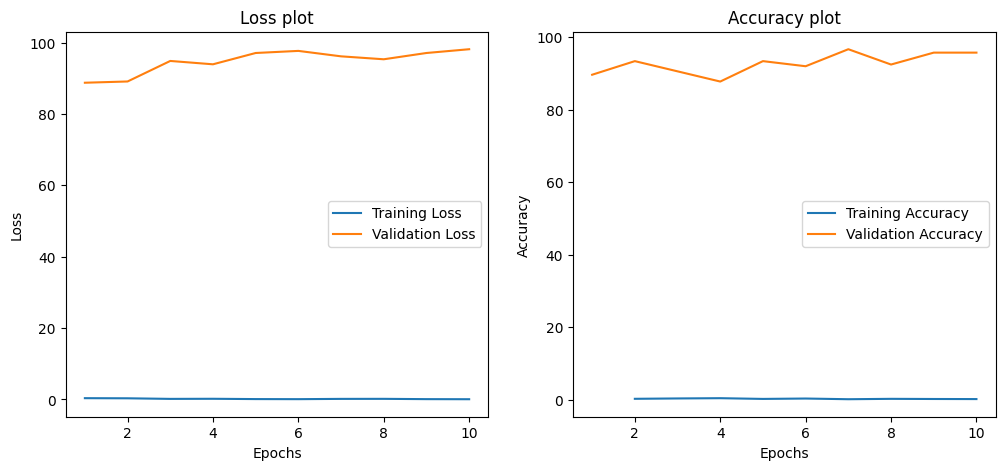

In [7]:
plt_metrics(train_losses, train_accuracies, val_losses, val_accuracies, epochs)

### Pre-Processing the data

This code snippet puts all images in directories corresponding to their label. <font color='red' >**Do not run it if they are already in their directories.**</font>

In [12]:
import os

# Define the classes
classes = ['cloudy', 'rain', 'shine', 'sunrise']

# Create subdirectories for each class if they don't exist
for cls in classes:
    os.makedirs(os.path.join("Test", cls), exist_ok=True)

# Move files to their respective class subdirectories
for file_name in os.listdir("Test"):
    file_path = os.path.join("Test", file_name)
    if os.path.isfile(file_path):
        for cls in classes:
            if cls in file_name:
                os.rename(file_path, os.path.join("Test", cls, file_name))
                break

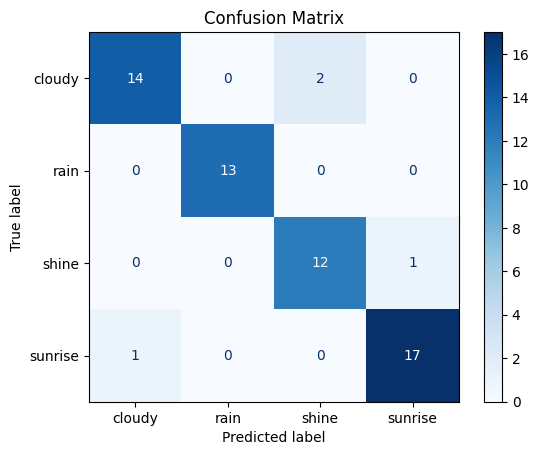

Test Accuracy: 93.33%
Total images tested: 60


In [8]:
# Define transformations for the test dataset
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the test dataset
test_dataset = datasets.ImageFolder("Test/", transform=test_transform)

# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Function to test the model and plot confusion matrix
def test_with_confusion_matrix(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            # Store labels and predictions for confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    # Calculate accuracy
    accuracy = 100 * correct / total

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_loader.dataset.classes)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, total

# Use the updated function
test_accuracy, total = test_with_confusion_matrix(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Total images tested: {total}")